In [4]:
import pandas as pd

input_data_chips = pd.read_csv("resources/Boost/chips.csv")
chips_xs = input_data_chips[input_data_chips.columns[:-1]].to_numpy()
chips_ys = input_data_chips[input_data_chips.columns[-1]].to_numpy()
chips_ys = list(map(lambda c: c == 'P', chips_ys))

input_data_geyser = pd.read_csv("resources/Boost/geyser.csv")
geyser_xs = input_data_geyser[input_data_geyser.columns[:-1]].to_numpy()
geyser_ys = input_data_geyser[input_data_geyser.columns[-1]].to_numpy()
geyser_ys = list(map(lambda c: c == 'P', geyser_ys))

In [12]:
from sklearn.tree import DecisionTreeClassifier
import math

class Stump:
    def __init__(self, tree, say):
        self.decision_tree = tree
        self.say = say

    def predict(self, xs):
        return self.decision_tree.predict(xs)


class AdaForest:
    def __create_ada_stump__(self, sample_weight, max_depth=2):
        tree = DecisionTreeClassifier(max_depth=max_depth)
        sample_weight = sample_weight if sample_weight is not None else [1 / len(self.xs) for _ in range(len(self.xs))]
        tree.fit(self.xs, self.ys, sample_weight)

        # count total error to compute amount of say
        incorrect = []
        total_error = 0  # 1e-10
        for i in range(len(self.xs)):
            if tree.predict([self.xs[i]]) != self.ys[i]:
                total_error += sample_weight[i]
                incorrect.append(i)
        say = math.log((1 - total_error) / total_error) / 2

        # compute and normalize weights for the next stump
        new_weight = []
        for i in range(len(sample_weight)):
            if i in incorrect:  # increase weight of this sample if it's incorrectly predicted
                new_weight.append(sample_weight[i] * math.exp(say))
            else:
                new_weight.append(sample_weight[i] * math.exp(-say))  # vice versa
        return Stump(tree, say), list(map(lambda e: e / sum(new_weight), new_weight))

    def __init__(self, size, xs, ys, stumps_depth):
        self.forest = []
        self.xs = xs
        self.ys = ys
        cur_weights = None
        for _ in range(size):
            stump, new_weights = self.__create_ada_stump__(cur_weights, stumps_depth)
            cur_weights = new_weights
            self.forest.append(stump)

    def predict(self, xs):
        res = 0
        for stump in self.forest:
            if stump.predict([xs]):
                res += stump.say
            else:
                res -= stump.say
        return res >= 0
    
    def predict_all(self, xs):
        res = []
        for x in xs:
            res.append(self.predict(x))
        return res

In [7]:
import matplotlib.pyplot as plt

def draw_plot(xs, ys, title, xlabel, ylabel):
    plt.plot(xs, ys)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

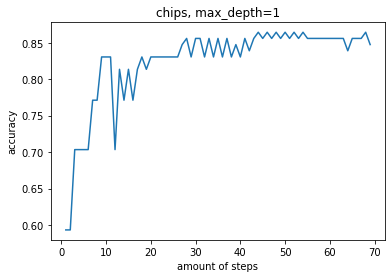

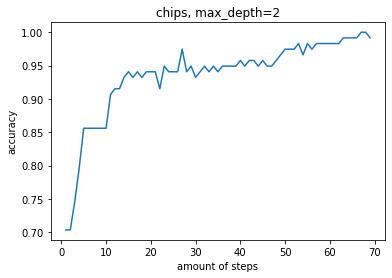

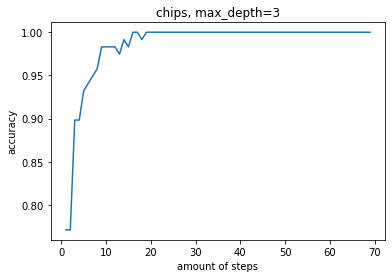

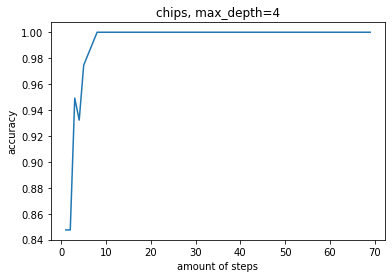

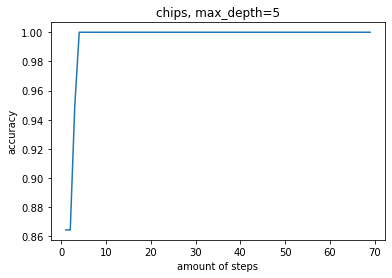

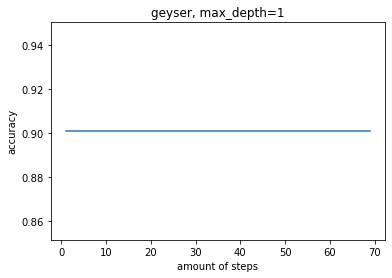

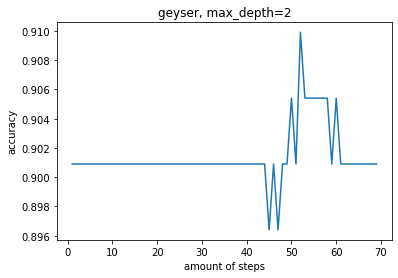

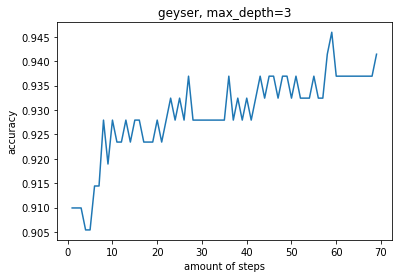

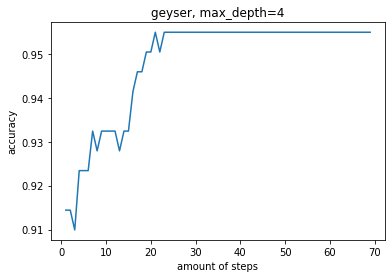

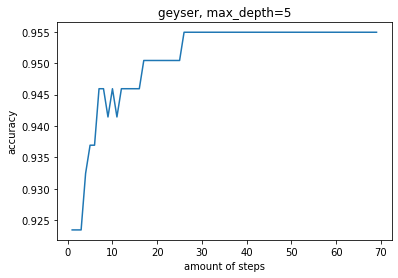

In [9]:
from sklearn.metrics import accuracy_score

dataset = [(chips_xs, chips_ys, 'chips'), (geyser_xs, geyser_ys, 'geyser')]
max_depths = [1, 2, 3, 4, 5]
for data in dataset:
    for max_depth in max_depths:
        accuracy = []
        for steps in range(1, 70):
            forest = AdaForest(steps, data[0], data[1], max_depth)
            predicted_ys = []
            for xs in data[0]:
                cur_y = forest.predict(xs)
                predicted_ys.append(cur_y)
            accuracy.append(accuracy_score(data[1], predicted_ys))
        draw_plot([i for i in range(1, 70)], accuracy, f'{data[2]}, max_depth={max_depth}', 'amount of steps', 'accuracy')

In [100]:
import numpy as np

def draw_classification_plot(xs, ys, steps, max_depth, title):
    x_axis = [x[0] for x in xs]
    y_axis = [x[1] for x in xs]

    min_x = min(x_axis) - 0.1
    max_x = max(x_axis) + 0.1

    min_y = min(y_axis) - 0.1
    max_y = max(y_axis) + 0.1

    plt.title(title)
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)

    x_true = []
    y_true = []
    x_false = []
    y_false = []

    s = 0.025
    mesh = np.meshgrid(np.arange(min_x, max_x, s), np.arange(min_y, max_y, h))
    all_points = np.array(mesh).T.reshape(-1, 2)

    forest = AdaForest(steps, xs, ys, max_depth)
    predicted = forest.predict_all(all_points)

    p_x_true = []
    p_y_true = []
    p_x_false = []
    p_y_false = []

    for i in range(len(x_axis)):
        if ys[i] is True:
            x_true.append(x_axis[i])
            y_true.append(y_axis[i])
        else:
            x_false.append(x_axis[i])
            y_false.append(y_axis[i])

    for i in range(len(all_points)):
        if predicted[i] is True:
            p_x_true.append(all_points[i][0])
            p_y_true.append(all_points[i][1])
        else:
            p_x_false.append(all_points[i][0])
            p_y_false.append(all_points[i][1])

    plt.scatter(p_x_true, p_y_true, marker='.', color='#90EE90', s=50)
    plt.scatter(p_x_false, p_y_false, marker='.', color='#FFC0CB', s=50)
    plt.scatter(x_true, y_true, marker='+', color='blue', s=50)
    plt.scatter(x_false, y_false, marker='_', color='red', s=50)
    plt.show()

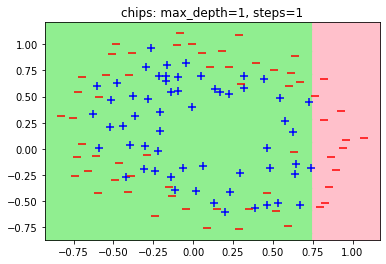

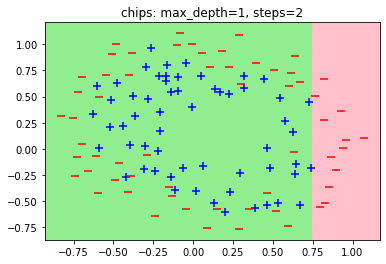

KeyboardInterrupt: 

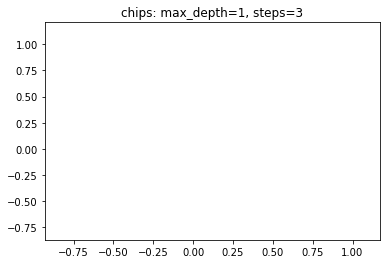

In [99]:
amount_of_steps = [1, 2, 3, 5, 8, 13, 21, 34, 55]
dataset = [(chips_xs, chips_ys, 'chips'), (geyser_xs, geyser_ys, 'geyser')]
for data in dataset:
    for max_depth in range(1, 5):
        for steps in amount_of_steps:
            draw_classification_plot(data[0],
                                     data[1],
                                     steps,
                                     max_depth,
                                     f"{data[2]}: max_depth={max_depth}, steps={steps}")